# Dependencies

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

# Loading Data

In [2]:
def table(name):    
    path = Path('D:/bootcamp/homeworks/tennis_project/data/raw/'+name)
    files = [str(file) for file in list(path.glob('*.parquet'))]
    return pd.concat([pd.read_parquet(file) for file in files], ignore_index = True)

In [3]:
away = table('raw_match_parquet/away_team')
home = table('raw_match_parquet/home_team')

players = pd.concat([away, home])

# Questions

## 1. How many tennis players are included in the dataset?

In [4]:
len(players['full_name'].unique())

596

In [5]:
players['full_name'].nunique()

596

The dataset includes 596 tennis players. 

## 3. who has the highest number of wins?

In [6]:
event= table('raw_match_parquet/event')

In [7]:
home_won = event[event['winner_code'] == 1]
away_won = event[event['winner_code'] == 2]

home_winners = home_won.merge(home[['full_name', 'country', 'match_id']], on='match_id')
away_winners = away_won.merge(away[['full_name', 'country', 'match_id']], on='match_id')
winners = pd.concat([home_winners, away_winners], axis='rows')

winners_count = winners.groupby('full_name', as_index=False)['match_id'].count()
winners_count[winners_count.match_id == winners_count.match_id.max()]

,full_name,match_id
147,"Kalina, Vit",3
221,"Milushev, Plamen",3
255,"Panaras, Adam",3


These three players won 3 matches that is the highest number of wins.

## 4. What is the longest match recorded in terms of duration?

In [8]:
time = table('raw_match_parquet/time')

In [9]:
time['duration'] = None
time.head()

,match_id,period_1,period_2,period_3,period_4,period_5,current_period_start_timestamp,duration
0,11673958,1960,2457,None,None,None,1696097817,None
1,11673962,None,None,None,None,None,1696176527,None
2,11673963,3403,2431,None,None,None,1696091852,None
3,11673993,2894,2309,2084,None,None,1696160248,None
4,11674000,3177,None,None,None,None,1696089777,None


In [10]:
# calculating duration
time.duration = (time['period_1']
            + time['period_2'].fillna(0)
            + time['period_3'].fillna(0)
            + time['period_4'].fillna(0)
            + time['period_5'].fillna(0))
# longest match
time.duration.max() / 60

213.91666666666666

## 5. How many sets are typically played in a tennis match?

In [11]:
power = table('raw_tennis_power_parquet')

In [12]:
sets = power.groupby('match_id', as_index=False)['set_num'].nunique()
sets.set_num.mean()

2.1853932584269664

Typically in a tennis match 2 sets are played.

## 6. Which country has produced the most successful tennis players?

In [13]:
# mask players with less than 100 rank
top_100_players = players[players['current_rank'].le(100)].drop_duplicates('full_name')

In [14]:
player_country = pd.DataFrame(top_100_players.groupby('country', as_index=False)['current_rank'].count())
player_country.sort_values(by='current_rank', ascending=False).head()

,country,current_rank
8,Czech Republic,9
23,USA,8
20,Russia,6
11,France,5
7,China,5


countries have the most successful tennis players according to our evaluation indicator. --> czech, USA, Russia, France, Italy

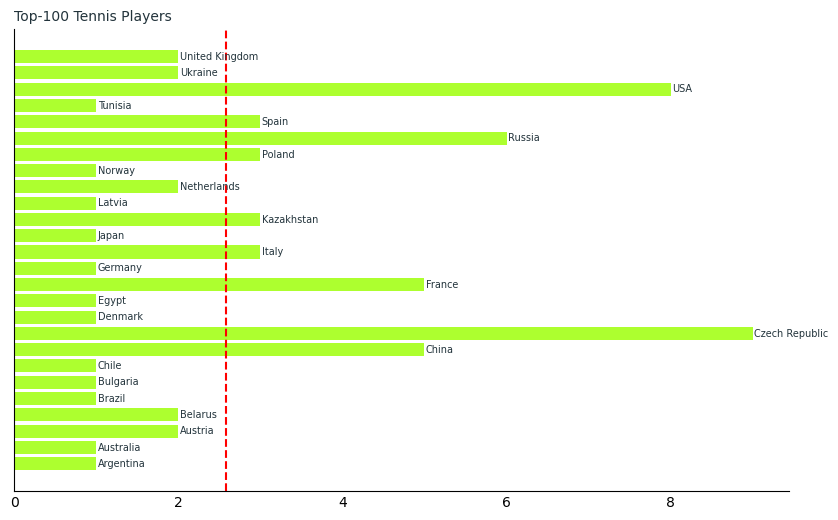

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

figure = ax.barh(player_country.country, player_country.current_rank, color='greenyellow')
ax.set_title('Top-100 Tennis Players', fontsize=10, color='#22333b', loc='left')
ax.bar_label(container=figure, labels=player_country.country, padding=1, fontsize=7, color='#22333b')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)
ax.axvline(x=player_country.current_rank.mean(), c='red', ls='--')
ax.set_yticklabels([])

plt.show()

bar-plot: number of top-100 tennis players in each country

In [16]:
# counties with most winners
winners.groupby('country', as_index=False)['match_id'].count().sort_values(by='match_id', ascending=False).head()

,country,match_id
19,France,55
25,Italy,39
1,Australia,30
0,Argentina,29
56,USA,27


countries have the most successful tennis players based on second indicator  --> France, Italy, Australia, Argentina, USA

## 7. What is the average number of aces per match?

In [17]:
stat = table('raw_statistics_parquet')

In [18]:
aces = stat[stat.statistic_name.eq('aces') & stat.period.eq('ALL')]
(aces.home_value + aces.away_value).sum()/aces.match_id.nunique()


4.009569377990431

about 4 aces occur per match.

## 8. Is there a difference in the number of double faults based on gender?

In [19]:
# mask statistics table
double_faults = stat[stat['statistic_name'].eq('double_faults') & stat.period.eq('ALL')]
# total number of double faults
double_faults['total'] = double_faults.home_value + double_faults.away_value

C:\Users\computer\AppData\Local\Temp\ipykernel_1296\1992830817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  double_faults['total'] = double_faults.home_value + double_faults.away_value


In [20]:
# merge with gender
faults_gender = double_faults.merge(players[['match_id', 'gender']], how='left', on='match_id')
# number of fault based on gender
final = faults_gender.groupby('gender', as_index=False).total.sum()

# calculate average of faults for each player
total_players = players.drop_duplicates('player_id').groupby('gender', as_index=False)['player_id'].count()
final2 = final.merge(total_players, on='gender')
final2['share'] = final2.total / final2.player_id

final2



,gender,total,player_id,share
0,F,1427,238,5.995798
1,M,654,358,1.826816


According to the table, females' number of double faults are significantly more than males.
As column 'share' shows, each woman does an average of 6 double faults while the number of double faults for each man is about 2. 

## 9. Which player has won the most tournaments in a single month?

In [21]:
tournaments = table('raw_match_parquet/tournament')

In [22]:
time = table('raw_match_parquet/time')

In [23]:
round1 = table('raw_match_parquet/round')

In [24]:
tour_time = tournaments.merge(time[['current_period_start_timestamp', 'match_id']], on='match_id')
tour_time['month'] = pd.to_datetime(tour_time['current_period_start_timestamp'], unit='s').dt.strftime('%B')
tour_time.head()

,match_id,tournament_id,tournament_name,tournament_slug,tournament_unique_id,tournament_category_name,tournament_category_slug,user_count,ground_type,tennis_points,has_event_player_statistics,crowd_sourcing_enabled,has_performance_graph_feature,display_inverse_home_away_teams,priority,competition_type,current_period_start_timestamp,month
0,11673958,121441,"Bogota, Colombia",bogota-colombia,None,Challenger,challenger,125,Red clay,125,False,False,False,False,0,2,1696097817,September
1,11673962,121441,"Bogota, Colombia",bogota-colombia,None,Challenger,challenger,125,Red clay,125,False,False,False,False,0,2,1696176527,October
2,11673963,121441,"Bogota, Colombia",bogota-colombia,None,Challenger,challenger,125,Red clay,125,False,False,False,False,0,2,1696091852,September
3,11673993,121451,"Braga, Portugal",braga-portugal,None,Challenger,challenger,163,Red clay,75,False,False,False,False,0,2,1696160248,October
4,11674000,121453,"Charleston, USA",charleston-usa,None,Challenger,challenger,71,Hardcourt outdoor,75,False,False,False,False,0,2,1696089777,September


In [25]:
final_tour = tour_time.merge(round1[round1.cup_round_type.eq(1)]).merge(winners[['full_name', 'match_id']], on='match_id')

final_tour.groupby(['full_name', 'tournament_name'], as_index=False)['tournament_id'].count()


,full_name,tournament_name,tournament_id
0,"Bartunkova, Nikola","S. Margherita Di Pula, Singles Main, W-ITF-ITA...",1
1,"Biolay, Sophia","Hilton Head, SC, Singles Main, W-ITF-USA-43A",1
2,"Cid Subervi, Roberto","Monastir, Singles Main, M-ITF-TUN-43A",1
3,"Draxl, Liam","Albuquerque, NM, Singles Main, M-ITF-USA-35A",1
4,"Gaubas, Vilius","Sabadell, Singles Main, M-ITF-ESP-30A",1
5,"Gjorcheska, Lina","Kursumlijska Banja, Singles Main, W-ITF-SRB-17A",1
6,"Glinka, Daniil","Forbach, Singles Main, M-ITF-FRA-19A",1
7,"Guerrero Alvarez, Eva","Santarem, Singles Main, W-ITF-POR-15A",1
8,"Guillen Meza, Alvaro","Lujan, Singles Main, M-ITF-ARG-07A",1
9,"Janicijevic, Selena","Lujan, Singles Main, W-ITF-ARG-09A",1


Each tournament has a different winner.

## 10. Is there a correlation between a player's height and their ranking?

In [26]:
corhr = players.drop_duplicates('player_id')[['height', 'current_rank']].corr()
round(corhr, 3)

,height,current_rank
height,1.000,0.033
current_rank,0.033,1.000


In [27]:
# correlation between height and rank in each gender
players.drop_duplicates('player_id').groupby('gender')[['height', 'current_rank']].corr()

height  current_rank
gender                                     
F      height        1.000000     -0.230161
       current_rank -0.230161      1.000000
M      height        1.000000     -0.159786
       current_rank -0.159786      1.000000

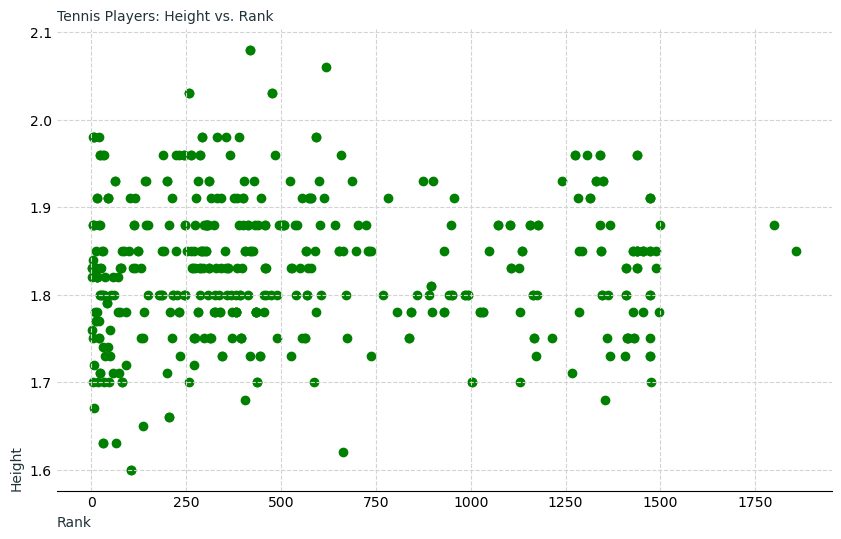

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(visible=True, color='lightgray', ls='--')
ax.scatter(players.current_rank, players.height, color='green')
ax.set_ylabel('Height', fontsize=10, color='#22333b', loc='bottom')
ax.set_xlabel('Rank', fontsize=10, color='#22333b', loc='left')
ax.set_title('Tennis Players: Height vs. Rank', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)

plt.show()

c:\Users\computer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


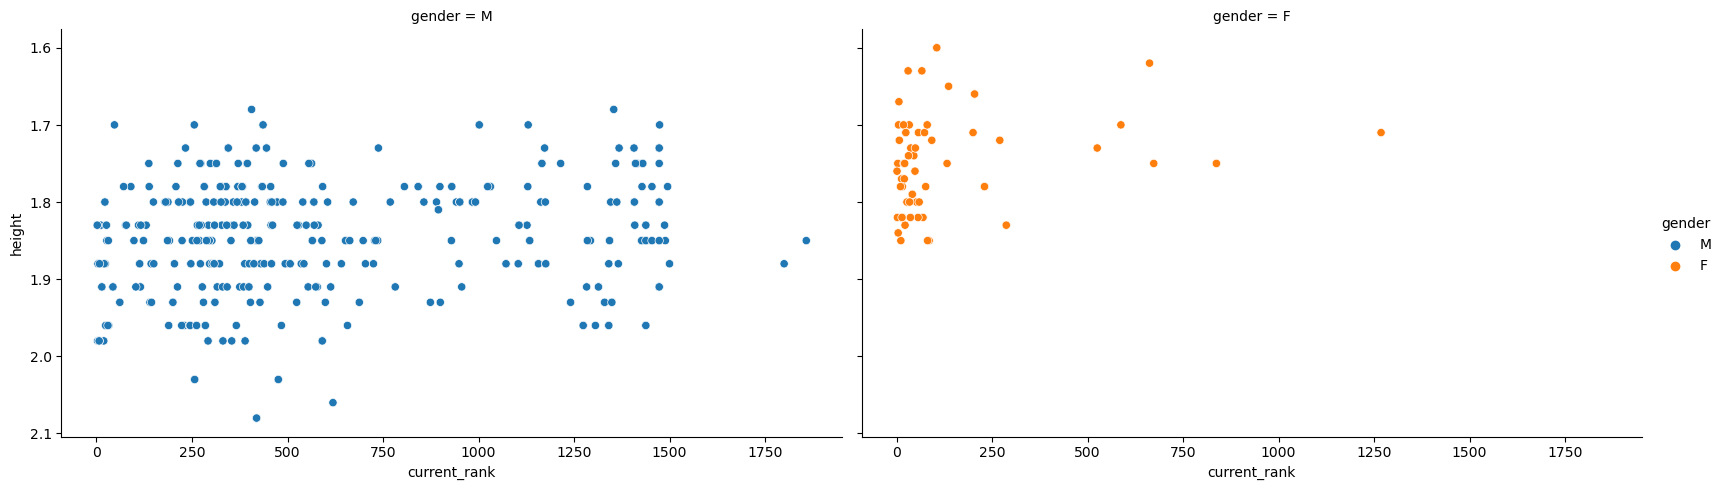

In [29]:
sns.relplot(data=players, x="current_rank", y="height", col='gender', hue="gender", kind="scatter", aspect=10/6)

Scatterplots:
If you ask me, there is no correlation between these two factors

## 11. What is the average duration of matches?

In [31]:
time['duration'] = None
# calculating duration
time.duration = (time['period_1']
            + time['period_2'].fillna(0)
            + time['period_3'].fillna(0)
            + time['period_4'].fillna(0)
            + time['period_5'].fillna(0))

In [32]:
time.duration.mean() / 60

100.398125

## 12. What is the average number of games per set in men's matches compared to women's matches?

In [33]:
# calculate the number of matches per set
set_game = power.groupby(['match_id', 'set_num'], as_index=False)['game_num'].count()
set_game

,match_id,set_num,game_num
0,11674074,1,12
1,11674074,2,7
2,11674103,1,10
3,11674103,2,8
4,11674105,1,13
...,...,...,...
384,11703470,2,9
385,11703524,1,8
386,11703524,2,7
387,11703525,1,10


In [34]:
game_gender = set_game.merge(players[['match_id', 'gender']], how='inner', on='match_id')
game_gender.groupby('gender', as_index=False)['game_num'].mean()

,gender,game_num
0,F,8.867021
1,M,9.213675


Generally there is no difference between the average of games per set between men and women's match

## 13. What is the distribution of left-handed versus right-handed players?

In [35]:
# handling missing values
available = players.drop_duplicates('player_id')[['plays', 'player_id']]

In [36]:
distribution = available.groupby('plays', as_index=False)['player_id'].count()
distribution

,plays,player_id
0,left-handed,32
1,right-handed,244


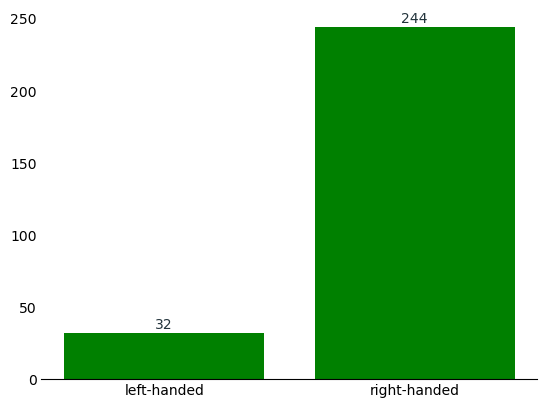

In [37]:
fig, ax = plt.subplots()

figure = plt.bar(distribution.plays, distribution.player_id, color='green')
ax.bar_label(container=figure, labels=distribution.player_id, padding=1, fontsize=10, color='#22333b')
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)

plt.show()

The majority of tennis players are right-handed.

## 14. What is the most common type of surface used in tournaments?

In [38]:
tournaments = table('raw_match_parquet/tournament')

In [39]:
surface = tournaments.groupby('ground_type', as_index=False)['match_id'].count()
surface.insert(loc=2, column='share', value=surface.match_id/surface.match_id.sum() *100)
surface.round(1).to_excel('surface.xlsx')

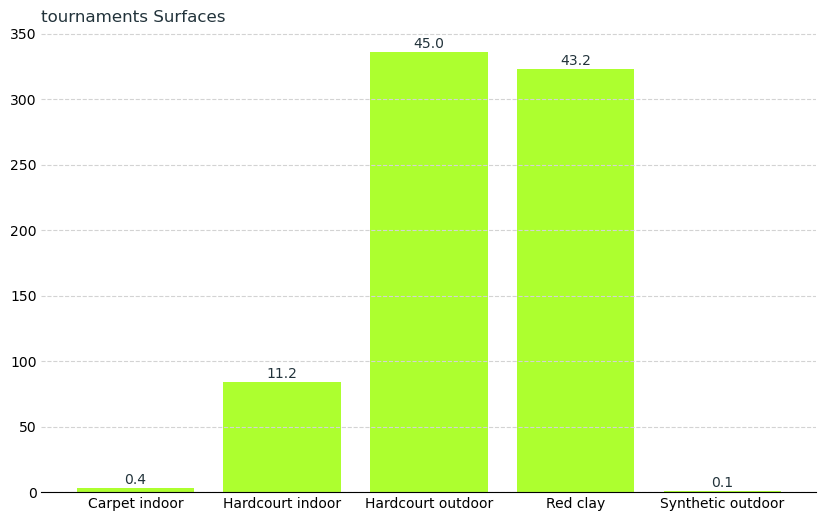

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(visible=True, axis='y', color='lightgray', ls='--')
figure = ax.bar(surface.ground_type, surface.match_id, color='greenyellow')
ax.set_title('tournaments Surfaces', fontsize=12, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)
ax.bar_label(container=figure, labels=surface.share.round(1), padding=1, fontsize=10, color='#22333b')

plt.savefig('surface_plot.png')

All type of surfaces in the tournaments. The most common is Hard court outdoor

## 15. How many distinct countries are represented in the dataset?

In [41]:
players['country'].nunique()

70

There are 70 distinct countries in the dataset.

## 16. Which player has the highest winning percentage against top 10 ranked opponents?

In [42]:
pbp = table('raw_point_by_point_parquet')

In [43]:
top_10_players = players[['match_id', 'full_name', 'current_rank']][players['current_rank'].le(10)]
top_10_players.to_excel('10player2.xlsx')

In [44]:
win_player = top_10_players.merge(winners[['full_name', 'match_id']], on='match_id', how='left')
semi_final = win_player[win_player.full_name_x == win_player.full_name_y]
top10 = semi_final.groupby('full_name_y', as_index=False).match_id.count()

top10[top10.match_id == top10.match_id.max()]


,full_name_y,match_id
0,"Alcaraz, Carlos",2
6,"Sinner, Jannik",2
8,"Zverev, Alexander",2


After comprizing the winners of the matches which top 10 players where in with the top 10 ranked players' name, we realize that these three top 10 ranked players win 2 games that means they have highest winning percentage against other top 10 players.

## 17. What is the average number of breaks of serve per match?

what others think:

In [45]:
breaks = power.groupby('match_id', as_index=False)['break_occurred'].sum()
breaks.break_occurred.sum() / breaks.match_id.nunique()

7.157303370786517

what I think:

In [46]:
played_serve = stat[stat.period.eq('ALL') & stat.statistic_name.eq('service_games_played')][['match_id', 'statistic_name', 'home_stat', 'away_stat']]
won_serve = stat[stat.period.eq('ALL') & stat.statistic_name.eq('service_games_won')][['match_id', 'statistic_name', 'home_stat', 'away_stat']]
df2 = played_serve.merge(won_serve, on='match_id')
df2['all_played_serve'] = df2.home_stat_x.astype('int64') + df2.away_stat_x.astype('int64')
df2['all_won_serve'] = df2.home_stat_y.astype('int64') + df2.away_stat_y.astype('int64')
df2['breaks'] = df2.all_played_serve - df2.all_won_serve
df2.breaks.mean()

7.435406698564593

# Analysis

## 1. Rank 1 player

In [47]:
players.loc[players['current_rank'].eq(1)]

,match_id,name,slug,gender,user_count,residence,birthplace,height,weight,plays,turned_pro,current_prize,total_prize,player_id,current_rank,name_code,country,full_name
48,11697126,Świątek I.,swiatek-iga,F,54206,None,"Warsaw, Poland",1.76,None,right-handed,2016,8214738,20493969,228272,1,SWI,Poland,"Swiatek, Iga"


The first rank tennis player.

## 2. Number of players in each country

In [48]:
# number of players in each country
numberofplayers = players.groupby('country', as_index=False)['full_name'].count()
#merge with number of top_100_rank in each country
countries = numberofplayers.merge(player_country, how='left', on='country').sort_values('full_name', ascending=False)
# calculate the percent of success
countries['success'] = countries['current_rank']/countries['full_name'] *100
# output
countries

,country,full_name,current_rank,success
22,France,85,5.0,5.882353
28,Italy,59,3.0,5.084746
62,USA,55,8.0,14.545455
1,Argentina,44,1.0,2.272727
23,Germany,40,1.0,2.500000
...,...,...,...,...
24,Greece,1,NaN,NaN
18,Dominican Republic,1,NaN,NaN
7,Bosnia & Herzegovina,1,NaN,NaN
6,Bolivia,1,NaN,NaN


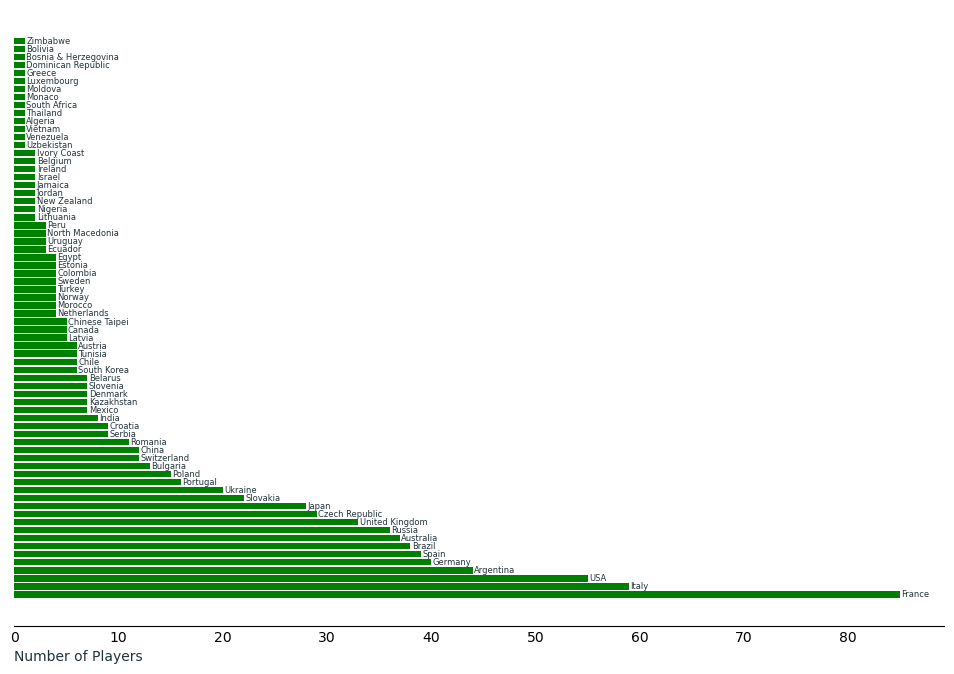

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

ax.grid(visible=False)
figure = plt.barh(countries.country, countries.full_name, color='green')
ax.set_xlabel('Number of Players', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)
ax.bar_label(container=figure, labels=countries.country, padding=1, fontsize=6, color='#22333b')
ax.set_yticklabels([])
plt.savefig('countries.png')

## 3. Distribution of male and female

In [50]:
# distribution of men and women
gender = pd.pivot_table(data=players, columns='gender', values=['player_id'], aggfunc='count')
# share of women
gender['share_f'] = round(gender.F/(gender.F + gender.M) * 100, 0)
# output
gender

gender,F,M,share_f
player_id,309,513,38.0


## 4. Average of match time in each ground_type

In [51]:
tour = tournaments.merge(time, on='match_id')
tour['duration'] = tour.period_1 + tour.period_2.fillna(0) + tour.period_3.fillna(0)
ground_time = tour.groupby('ground_type', as_index=False)['duration'].mean()
ground_time

,ground_type,duration
0,Carpet indoor,4745.0
1,Hardcourt indoor,5745.487805
2,Hardcourt outdoor,6099.772358
3,Red clay,6203.754545
4,Synthetic outdoor,1812.0


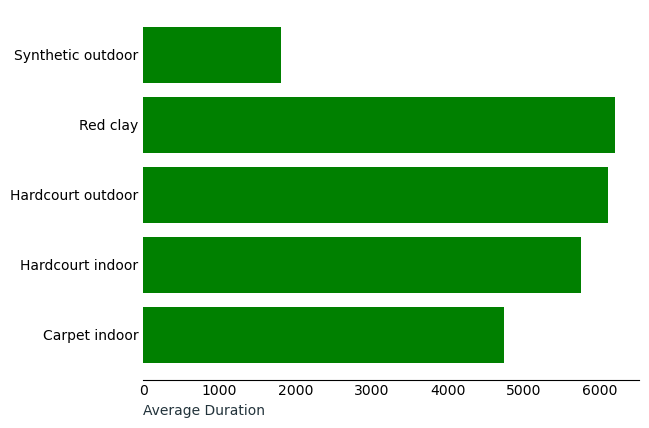

In [52]:
fig, ax = plt.subplots()

ax.grid(visible=False)
plt.barh(ground_time.ground_type, ground_time.duration, color='green')
ax.set_xlabel('Average Duration', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'left', 'top']].set_visible(False)

plt.savefig('ground_time.png')

## 5. correlation between aces and height in home

In [53]:
home_aces = aces.merge(home[['height', 'match_id']], on='match_id')
home_aces[['height', 'home_stat']].corr()

,height,home_stat
height,1.000000,0.542239
home_stat,0.542239,1.000000


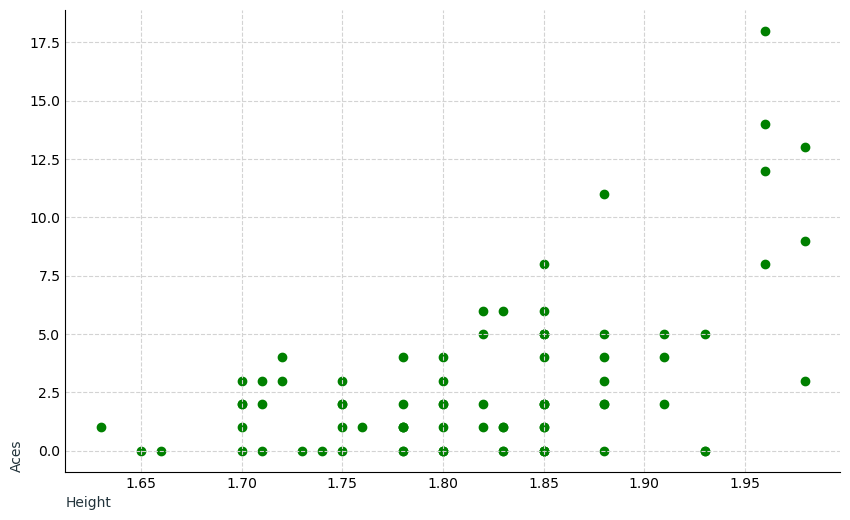

In [54]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(visible=True, color='lightgray', ls='--')
ax.scatter(home_aces.height.astype('float64'), home_aces.home_stat.astype('float64'), color='green')
ax.set_ylabel('Aces', fontsize=10, color='#22333b', loc='bottom')
ax.set_xlabel('Height', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('height_aces.png')

You can see a meaningful correlation between players' height and aces. It means that taller players have more successful aces.

## 6. Height histogram based on gender

In [55]:
height = home.height.dropna()
women_height = home[home['gender'] == 'F'].height.dropna()
men_height = home[home['gender'] == 'M'].height.dropna()

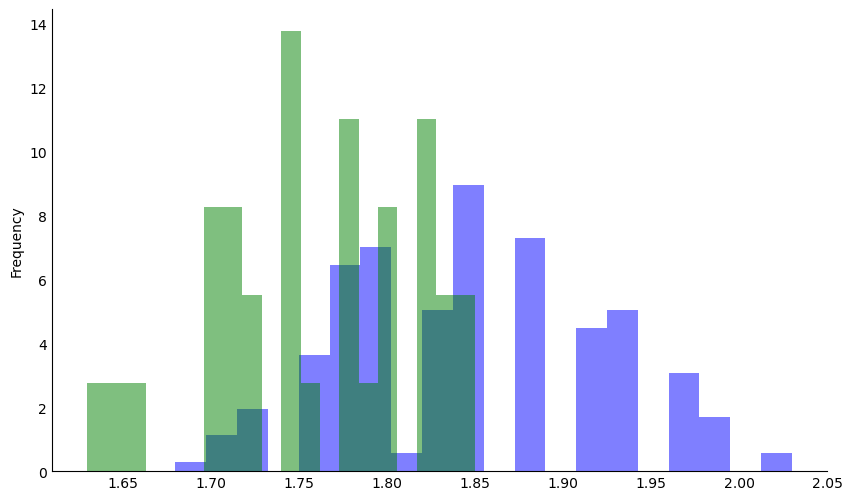

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
men_height.plot.hist(bins=20, density=True, alpha=0.5, color='b')
women_height.plot.hist(bins=20, density=True, alpha=0.5, color='g')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig('height_histogram.png')

Distribution of height based on gender id bimodal.

## 7. Match Predictions: Correct or Incorrect

In [57]:
votes = table('raw_votes_parquet')

In [58]:
vote_win = votes.merge(winners[['winner_code','match_id']], on='match_id')

In [59]:
for ind in vote_win.index:
    if vote_win.at[ind, 'winner_code'] == 1:
        vote_win.at[ind, 'team'] = 'home'
    elif vote_win.at[ind, 'winner_code'] == 2:
        vote_win.at[ind, 'team'] = 'away'

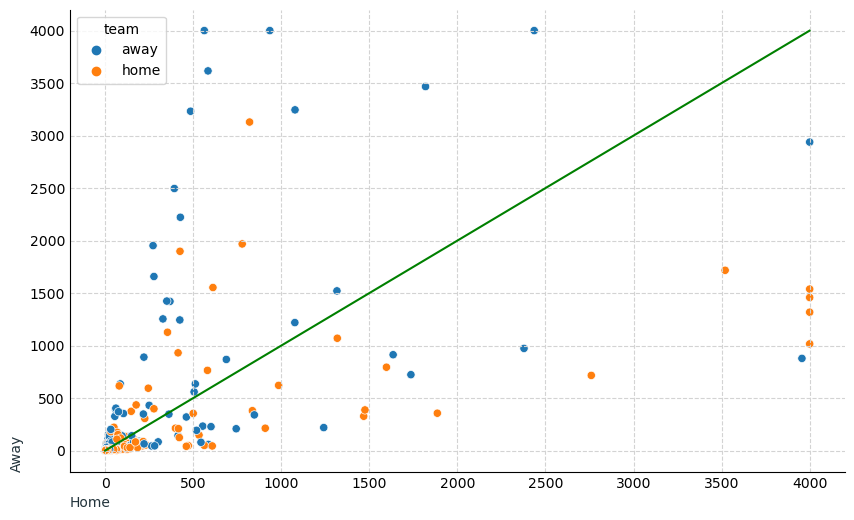

In [60]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(visible=True, color='lightgray', ls='--')
sns.scatterplot(data=vote_win, x=vote_win.home_vote.clip(upper=4000), y=vote_win.away_vote.clip(upper=4000), hue='team')
ax.set_ylabel('Away', fontsize=10, color='#22333b', loc='bottom')
ax.set_xlabel('Home', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)
plt.plot(range(4000), range(4000), color='g')
plt.savefig('votesscatter.png')


In [61]:
predict_home = votes[votes['home_vote'] > votes['away_vote']]
predict_away = votes[votes['home_vote'] < votes['away_vote']]
predict_eq = votes[votes['home_vote'] == votes['away_vote']]
correct_predict_home = pd.merge(home_won, predict_home, on='match_id')
correct_predict_away = pd.merge(away_won, predict_away, on='match_id')
correct_predict = pd.concat([correct_predict_home, correct_predict_away], axis='rows')
cr = correct_predict.match_id.size

In [62]:
incorrect_predict_home = pd.merge(away_won, predict_home, on='match_id')
incorrect_predict_away = pd.merge(home_won, predict_away, on='match_id')
incorrect_predict = pd.concat([incorrect_predict_home, incorrect_predict_away], axis='rows')
ic = incorrect_predict.match_id.size

print(f'There were {cr} correct predictions and {ic} incorrect ones')

There were 481 correct predictions and 220 incorrect ones


## 8. serve Analysis

In [63]:
df1 = stat[stat.period.eq('ALL') & stat.statistic_name.eq('first_serve')]
df1['home_percent'] = round(df1.home_value / df1.home_total * 100, 0)
df1['away_percent'] = round(df1.away_value / df1.away_total * 100, 0)
for ind in df1.index:
    if df1.at[ind, 'home_percent'] > df1.at[ind, 'away_percent']:
        df1.at[ind, 'team'] = 'home'
    elif df1.at[ind, 'home_percent'] < df1.at[ind, 'away_percent']:
        df1.at[ind, 'team'] = 'away'

df1.set_index(np.arange(0,209)).head()

C:\Users\computer\AppData\Local\Temp\ipykernel_1296\616264445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['home_percent'] = round(df1.home_value / df1.home_total * 100, 0)
C:\Users\computer\AppData\Local\Temp\ipykernel_1296\616264445.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['away_percent'] = round(df1.away_value / df1.away_total * 100, 0)
C:\Users\computer\AppData\Local\Temp\ipykernel_1296\616264445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,match_id,period,statistic_category_name,statistic_name,home_stat,away_stat,compare_code,statistic_type,value_type,home_value,away_value,home_total,away_total,home_percent,away_percent,team
0,11674074,ALL,service,first_serve,34/52 (65%),26/57 (46%),1,positive,team,34,26,52.0,57.0,65.0,46.0,home
1,11674103,ALL,service,first_serve,31/57 (54%),33/52 (63%),2,positive,team,31,33,57.0,52.0,54.0,63.0,away
2,11674105,ALL,service,first_serve,75/114 (66%),80/121 (66%),2,positive,team,75,80,114.0,121.0,66.0,66.0,NaN
3,11674110,ALL,service,first_serve,39/50 (78%),51/73 (70%),1,positive,team,39,51,50.0,73.0,78.0,70.0,home
4,11674111,ALL,service,first_serve,24/49 (49%),31/53 (58%),2,positive,team,24,31,49.0,53.0,49.0,58.0,away


In [64]:
ave_home = round(df1.home_percent.mean(), 0)
ave_away = round(df1.away_percent.mean(), 0)
print(f'{ave_home} services of home players and {ave_away} services of away players were successful')

63.0 services of home players and 62.0 services of away players were successful


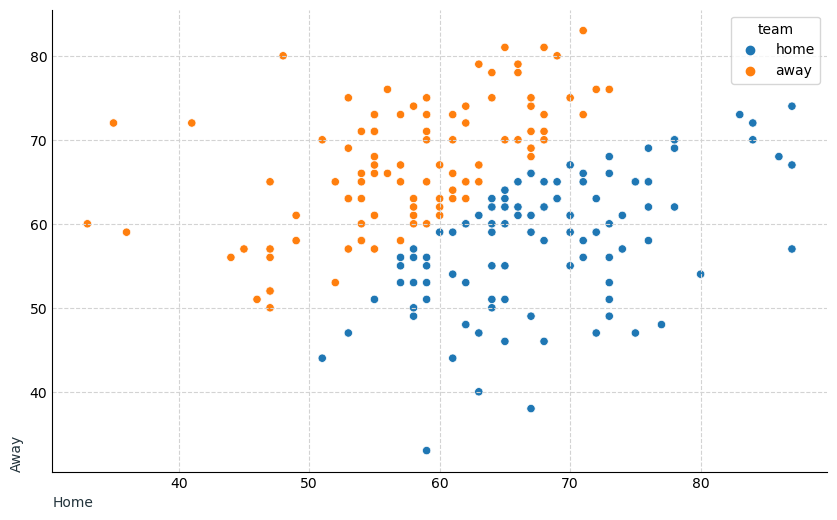

In [65]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(visible=True, color='lightgray', ls='--')
sns.scatterplot(data=df1, x='home_percent', y='away_percent', hue='team')
ax.set_ylabel('Away', fontsize=10, color='#22333b', loc='bottom')
ax.set_xlabel('Home', fontsize=10, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)

plt.show()


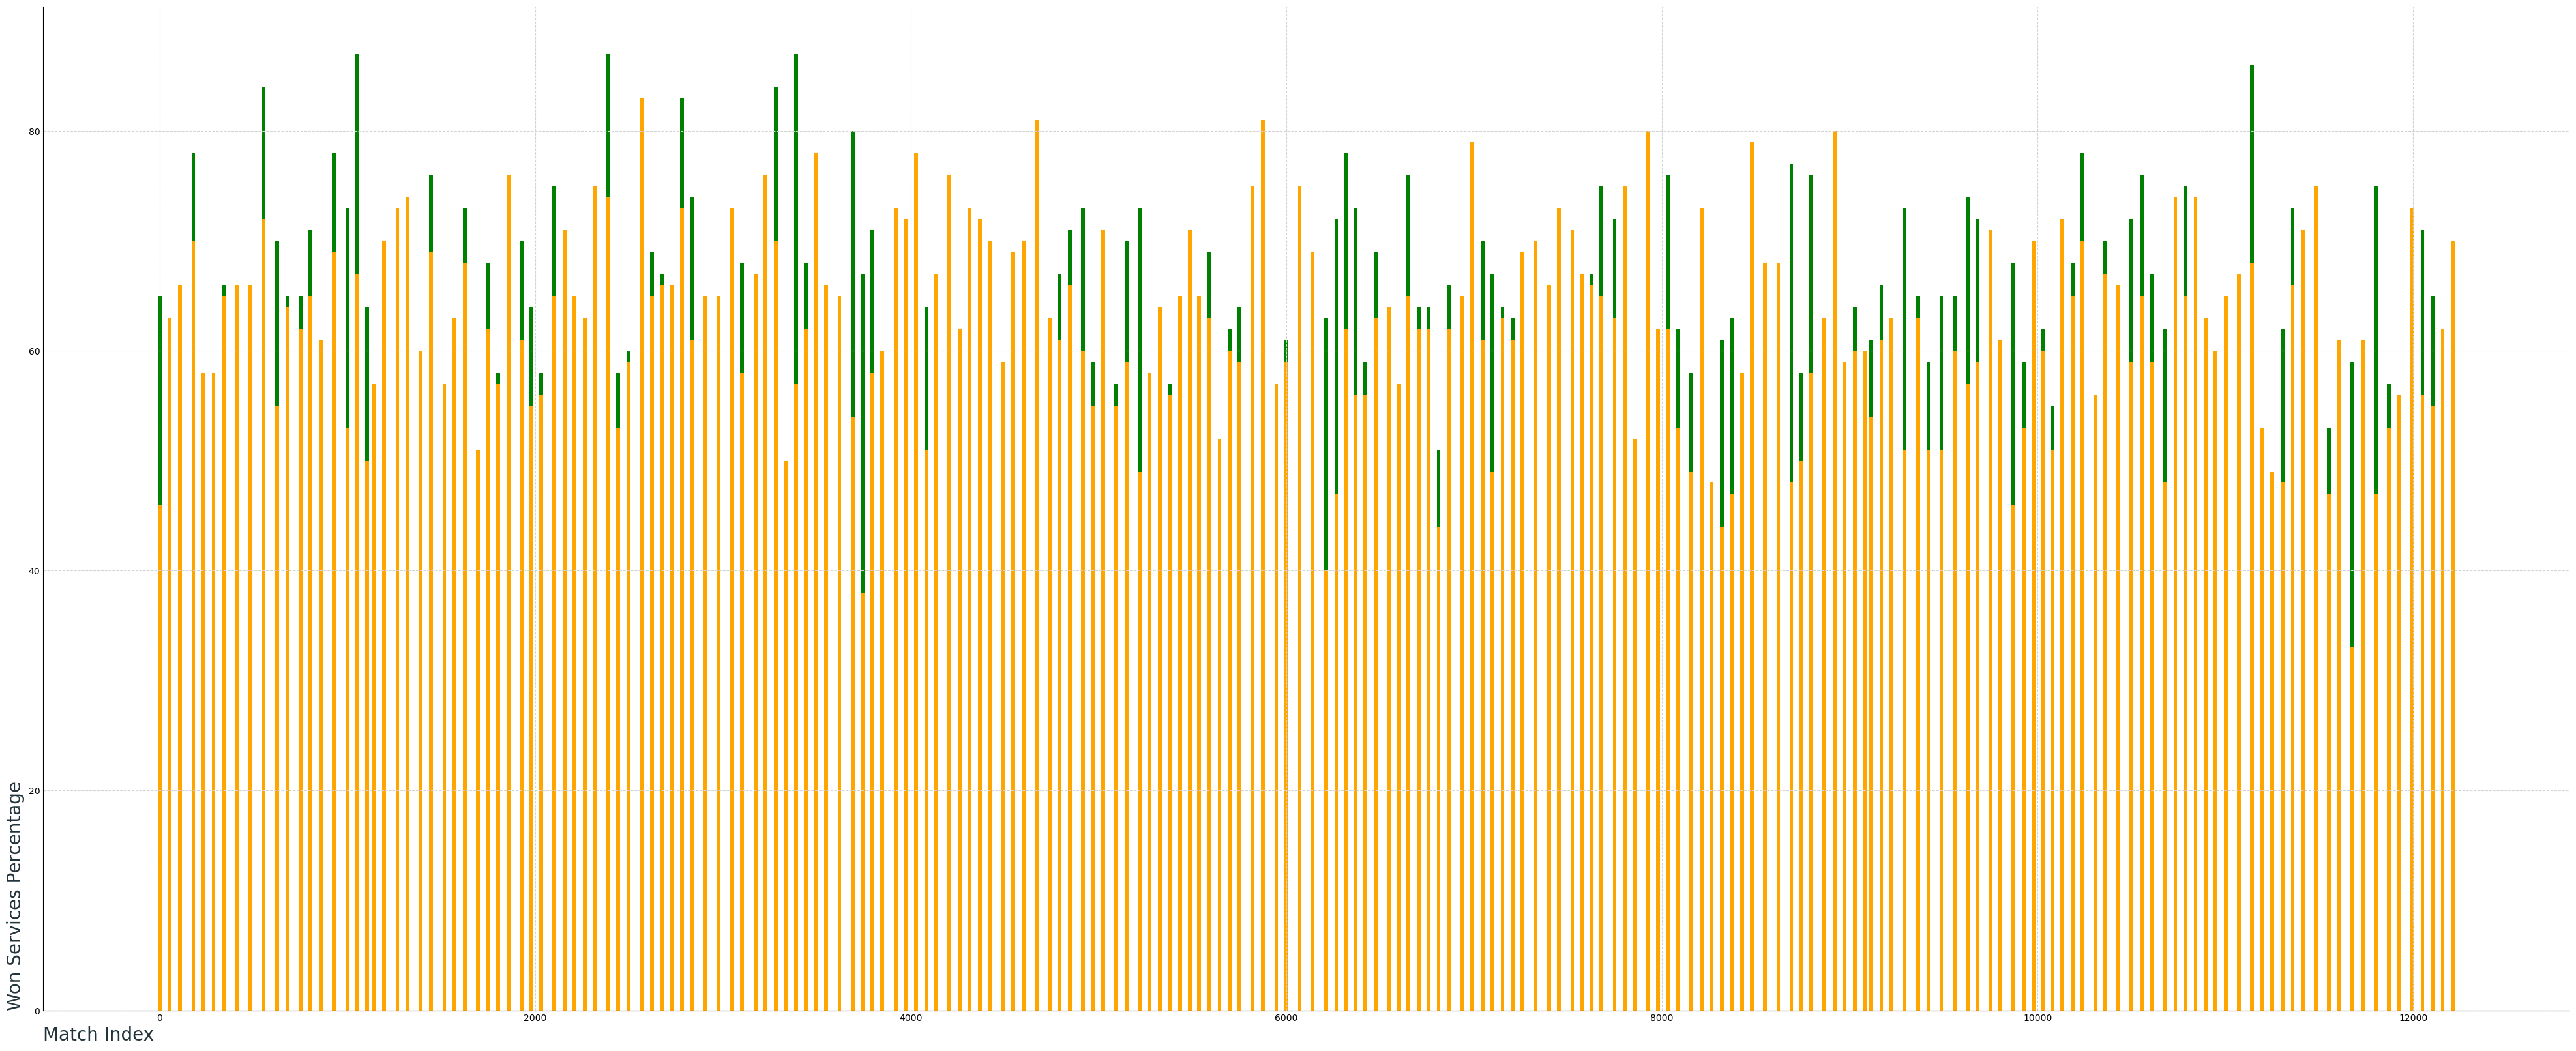

In [66]:
fig, ax = plt.subplots(figsize=(50, 20))

ax.grid(visible=True, color='lightgray', ls='--')
plt.bar(df1.index, df1.home_percent, width=20, color='g')
plt.bar(df1.index, df1.away_percent, width=20, color='orange')
ax.set_ylabel('Won Services Percentage', fontsize=20, color='#22333b', loc='bottom')
ax.set_xlabel('Match Index', fontsize=20, color='#22333b', loc='left')
ax.tick_params(length=0)
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('serve.png')

As it is visible from the bar plot home players had more successful services it may due to their lower stress level.